In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set(font_scale=1.2)
sns.set_style('whitegrid')
#%matplotlib inline

In [2]:
model_testing = 'y'
data_checks = 'y' # y -> visualize data and correlation plots (it takes a while to execute the merged pairplot)
preproc_log = 'n' # se lo accendo non impara più nulla, con lo Z invece funziona
remove_outliers = True

# hyperparameters: learning_rate, batch_size, 
# choice of the optimizer (algorithm)

# Features W -> e + nu
Run number of the event, Event number, pt eta phi are the electron's kinematics variables, Q is electron's charge, type is where they found the electron (in the barrel or the endcap), the del- features and sigmaEtaEta are the differences between the track variable and the one of the cluster, HoverE is the ratio of the electron's energy measured HCAL/ECAL, iso are parameters associated to electron detection, MET features refer to the kinematics of the neutrino

In [3]:
df_enu = pd.read_csv('~/Documents/tesi/thesis_notebooks/input_datasets/Wenu.csv')
df_enu['type'] = df_enu['type'].map({'EB': 0, 'EE': 1})

In [4]:
if data_checks=='y':
    df_enu.info()
    df_enu.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Run          100000 non-null  int64  
 1   Event        100000 non-null  int64  
 2   pt           100000 non-null  float64
 3   eta          100000 non-null  float64
 4   phi          100000 non-null  float64
 5   Q            100000 non-null  int64  
 6   type         100000 non-null  int64  
 7   delEta       100000 non-null  int64  
 8   delPhi       100000 non-null  int64  
 9   sigmaEtaEta  100000 non-null  float64
 10  HoverE       100000 non-null  float64
 11  isoTrack     100000 non-null  float64
 12  isoEcal      100000 non-null  float64
 13  isoHcal      100000 non-null  float64
 14  MET          100000 non-null  float64
 15  phiMET       100000 non-null  float64
dtypes: float64(10), int64(6)
memory usage: 12.2 MB


In [5]:
# to uniform datasets
df_enu['iso'] = df_enu.apply(lambda x: x['isoTrack'] + x['isoEcal'] + x['isoHcal'],axis=1)
if data_checks=='y':
    df_enu.head(3)

## Data visualization, W -> e + nu
we will introduce `df_enu_scaled` and `dfenu_array_to_dfenu` for the visualization WITH OUTLIERS, while `dfenu_filtered` and `dfenu_scaled_filtered` are for the visualization WITHOUT OUTLIERS

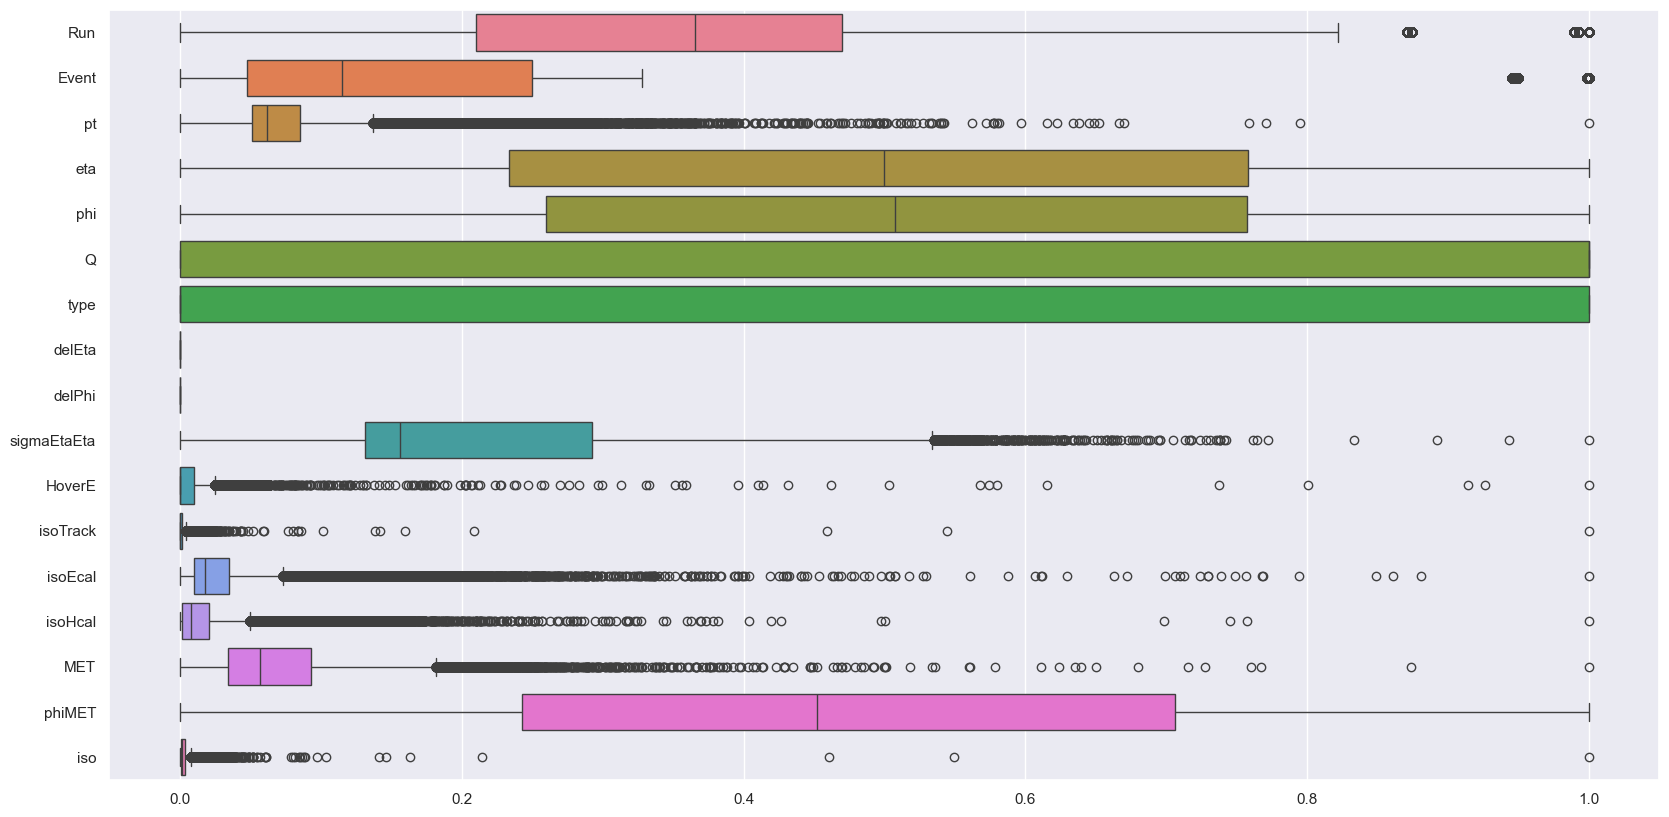

In [6]:
if data_checks=='y':
    scaler = preprocessing.MinMaxScaler()
    df_enu_scaled = scaler.fit_transform(df_enu)
    dfenu_array_to_dfenu = pd.DataFrame(df_enu_scaled, columns = df_enu.columns)
    # aesthetics
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    # boxplot
    sns.boxplot(data=dfenu_array_to_dfenu, orient="h", whis=1.5)

**Boxplot comment**: pt e MET sono gli unici che presentano *outliers* tra le feature che mi interessano. The coloured rectangle covers the range 25-75 quantile, while the whiskers reach to 1.5 times the distance between 25-75th percentile in both directions

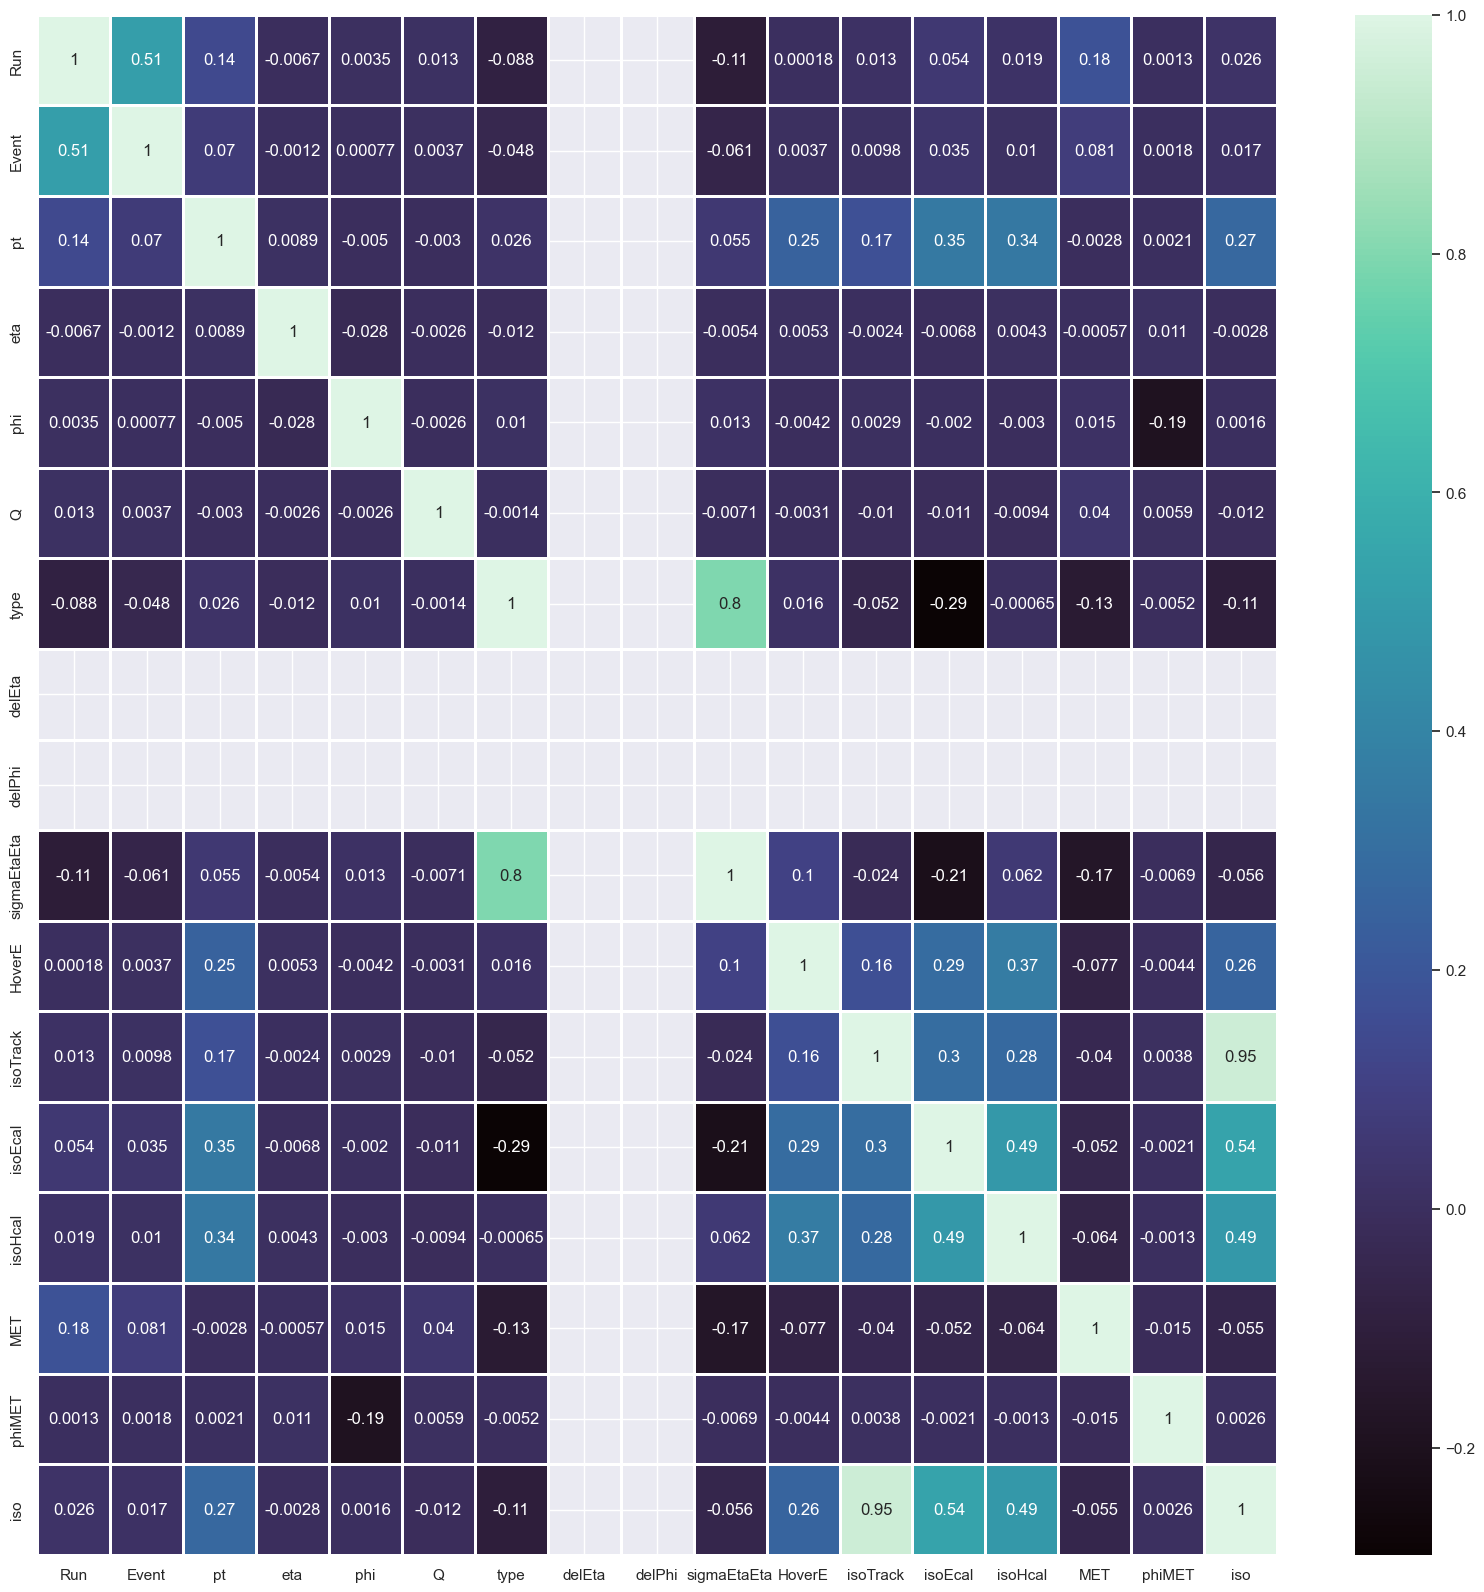

In [7]:
if data_checks=='y':
    fig, ax = plt.subplots(figsize=(20,20))
    # sns.set(font_scale=1.0)
    sns.heatmap(df_enu.corr() , annot= True, linewidths=2, ax=ax, cmap='mako')

## Removing outliers

### first from visualization…

In [8]:
cutoff_scal_pt_e_e = dfenu_array_to_dfenu['pt'].quantile(0.95)
cutoff_scal_MET_e = dfenu_array_to_dfenu['MET'].quantile(0.95)

# excluded_e = dfenu_array_to_dfenu[(dfenu_array_to_dfenu['pt']>cutoff_pt) | (dfenu_array_to_dfenu['MET']>cutoff_MET)]
dfenu_filtered = dfenu_array_to_dfenu[(dfenu_array_to_dfenu['pt']<cutoff_scal_pt_e_e) & (dfenu_array_to_dfenu['MET']<cutoff_scal_MET_e)]
print(len(dfenu_array_to_dfenu))
#print(len(excluded))
len(dfenu_filtered)

100000


90311

<Axes: >

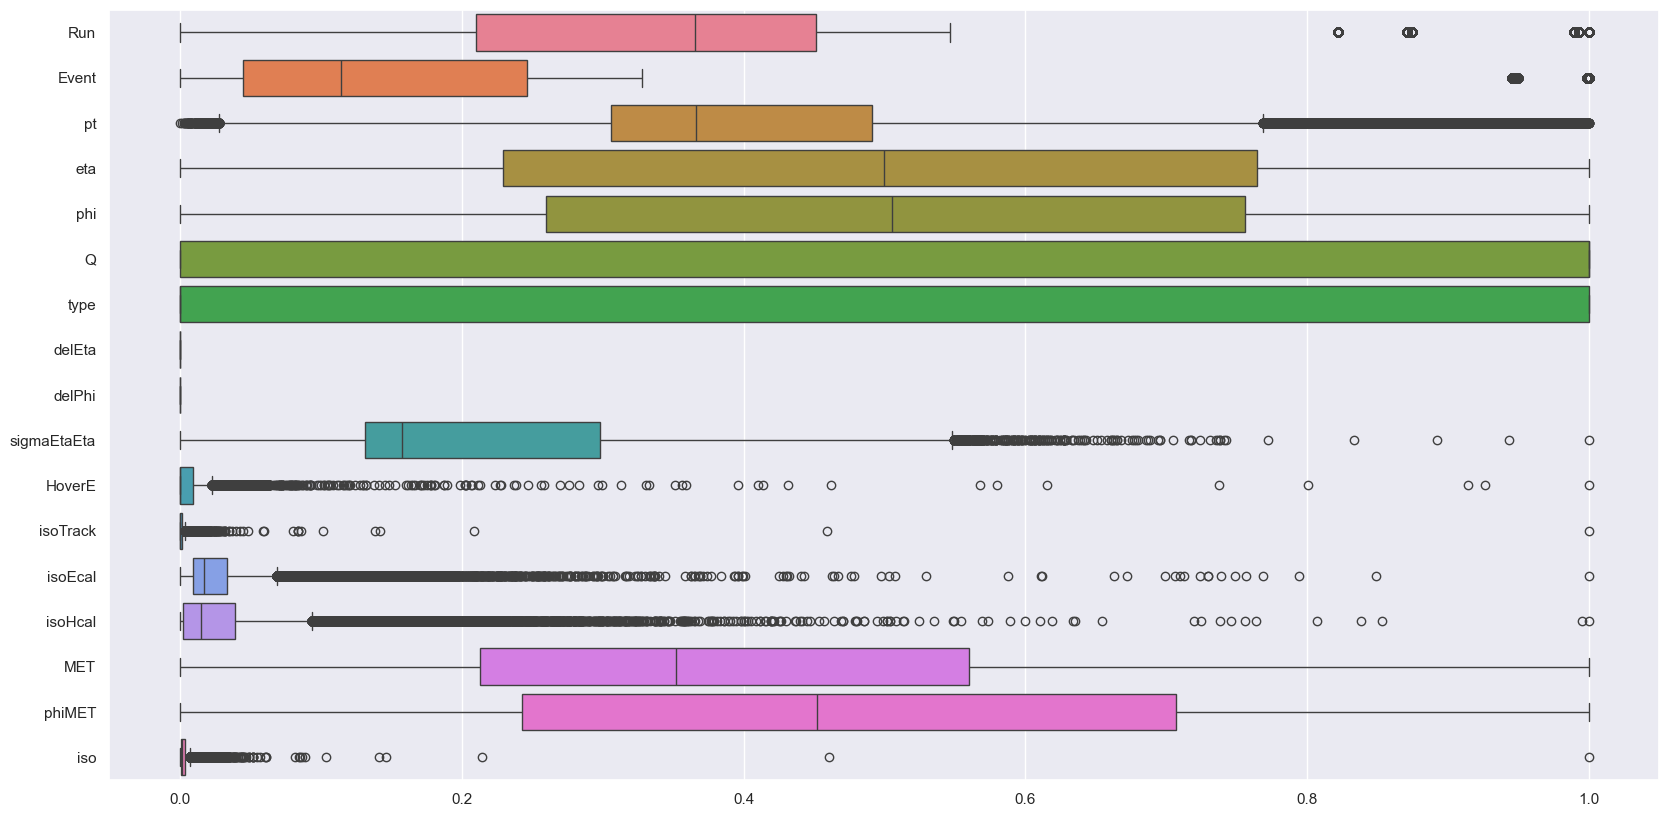

In [9]:
# boxplot again without the outliers
dfenu_scaled_filtered = scaler.fit_transform(dfenu_filtered)
dfenu_filtered = pd.DataFrame(dfenu_scaled_filtered, columns = dfenu_filtered.columns)
# aesthetics
plt.figure(figsize=(20, 10)) 
sns.set(font_scale=1.0)
# boxplot
sns.boxplot(data=dfenu_filtered, orient="h")

### …then from the real dataframe

In [10]:
df_e = df_enu[['pt','eta','phi','Q','iso','MET','phiMET']]

if remove_outliers:
    cutoff_pt_e = df_enu['pt'].quantile(.95)
    cutoff_MET_e = df_enu['MET'].quantile(.95)
    df_e = df_e[(df_e['pt']<cutoff_pt_e) & (df_e['MET']<cutoff_MET_e)]

# Adding 'class' because of dataset merging 
class_col = []
for i in range(len(df_e['pt'])):
    class_col.append('enu')
    
df_e.loc[:,'class'] = class_col

<Figure size 2000x1000 with 0 Axes>

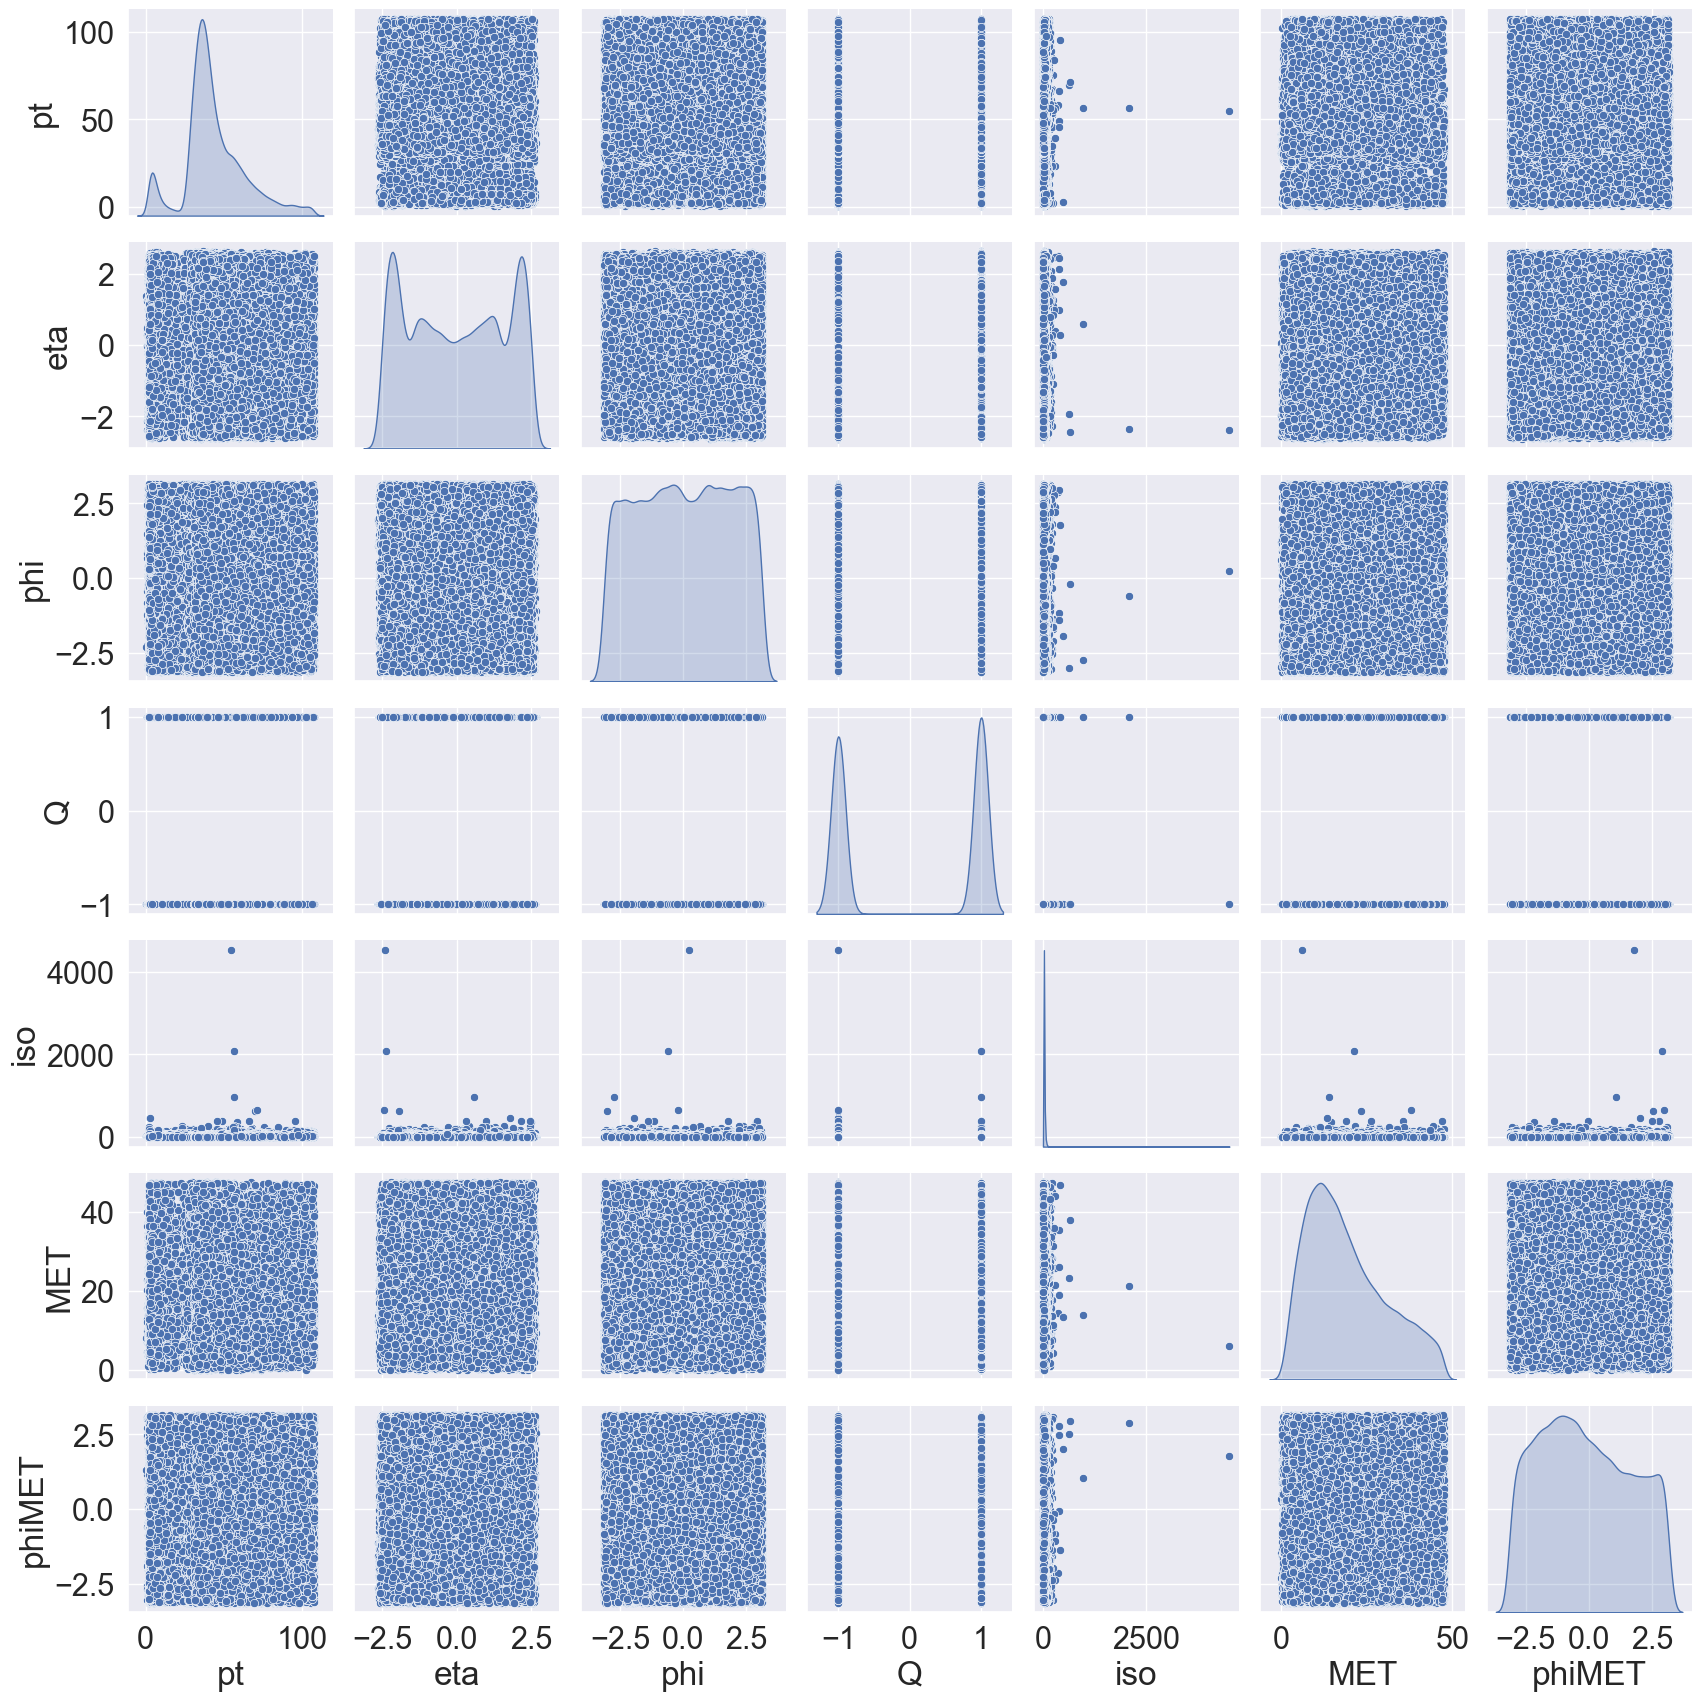

In [11]:
if data_checks=='y':
    # Unnecessary features already discarded (pairplot on df_e, not df_enu)
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    sns.pairplot(df_e, diag_kind='kde')

**Pairplot comment**: the features don't exhibit evident patters, they all seem to carry independent information

# Features W -> mu + nu
chisq is divided by dof, the kinematics features come from fits on data so chisq abnormally high should just be left out of the training of the network, because even if they were decay events they exhibit a peculiar behaviour (like outliers) and the network is not designed to take care of such fine phenomena (in the case they were ), dxy is the impact parameter, the iso parameter represents the threshold for the cluster to be identifyed as the trace/sign of an muon 

In [12]:
df_munu = pd.read_csv('~/Documents/tesi/thesis_notebooks/input_datasets/Wmunu.csv')

In [13]:
if data_checks=='y':
    df_munu.info()
    df_munu.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Run     100000 non-null  int64  
 1   Event   100000 non-null  int64  
 2   pt      100000 non-null  float64
 3   eta     100000 non-null  float64
 4   phi     100000 non-null  float64
 5   Q       100000 non-null  int64  
 6   chiSq   100000 non-null  float64
 7   dxy     100000 non-null  float64
 8   iso     100000 non-null  float64
 9   MET     100000 non-null  float64
 10  phiMET  100000 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 8.4 MB


Let's get rid of the events with an high chisq

In [14]:
chisq_th = 10 # threshold for acceptance of the data. It is a reduced chi squared!
not_trustworthy = df_munu[df_munu['chiSq'] > chisq_th]
len(not_trustworthy)

4802

In [15]:
df_munu.drop(not_trustworthy.index, inplace=True)
# print(len(df_munu[df_munu['chiSq']>100]))

## Data visualization, W -> mu + nu

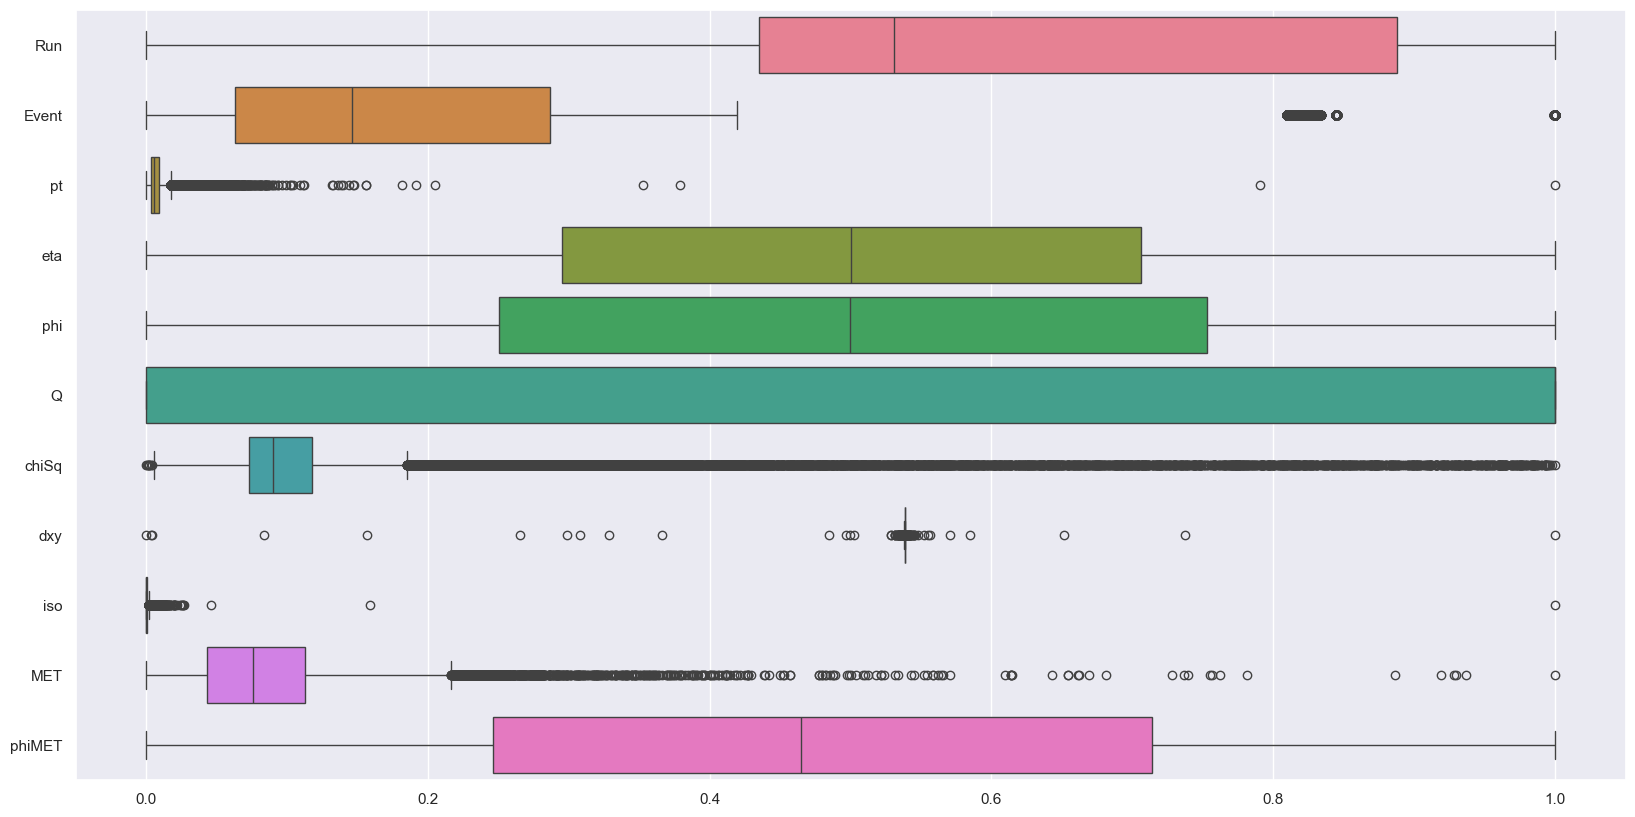

In [16]:
if data_checks=='y':
    scaler = preprocessing.MinMaxScaler()
    df_munu_scaled = scaler.fit_transform(df_munu)
    dfmunu_array_to_dfmunu = pd.DataFrame(df_munu_scaled, columns = df_munu.columns)
    # aesthetics
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    # boxplot
    sns.boxplot(data=dfmunu_array_to_dfmunu, orient="h")

Di nuovo pt e MET sono quelli con outliers (tra le features che mi interessano). Per il chi quadro devo scegliere una soglia, come se stessi facendo un test statistico (per quanto non possa essere ben fatto dal momente che nn ho la minima idea dei gradi di libertà della cosa)

## Removing outliers

### first from visualization…

In [17]:
cutoff_scal_pt_mu = dfmunu_array_to_dfmunu['pt'].quantile(0.95)
cutoff_scal_MET_mu = dfmunu_array_to_dfmunu['MET'].quantile(0.95)

# excluded_mu = dfmunu_array_to_dfmunu[(dfmunu_array_to_dfmunu['pt']>cutoff_scal_pt_nu) | (dfenu_array_to_dfmunu['MET']>cutoff_scal_MET_nu)]
dfmunu_filtered = dfmunu_array_to_dfmunu[(dfmunu_array_to_dfmunu['pt']<cutoff_scal_pt_mu) & (dfmunu_array_to_dfmunu['MET']<cutoff_scal_MET_mu)]
print(len(dfmunu_array_to_dfmunu))
#print(len(excluded_mu))
len(dfmunu_filtered)

95198


86231

<Axes: >

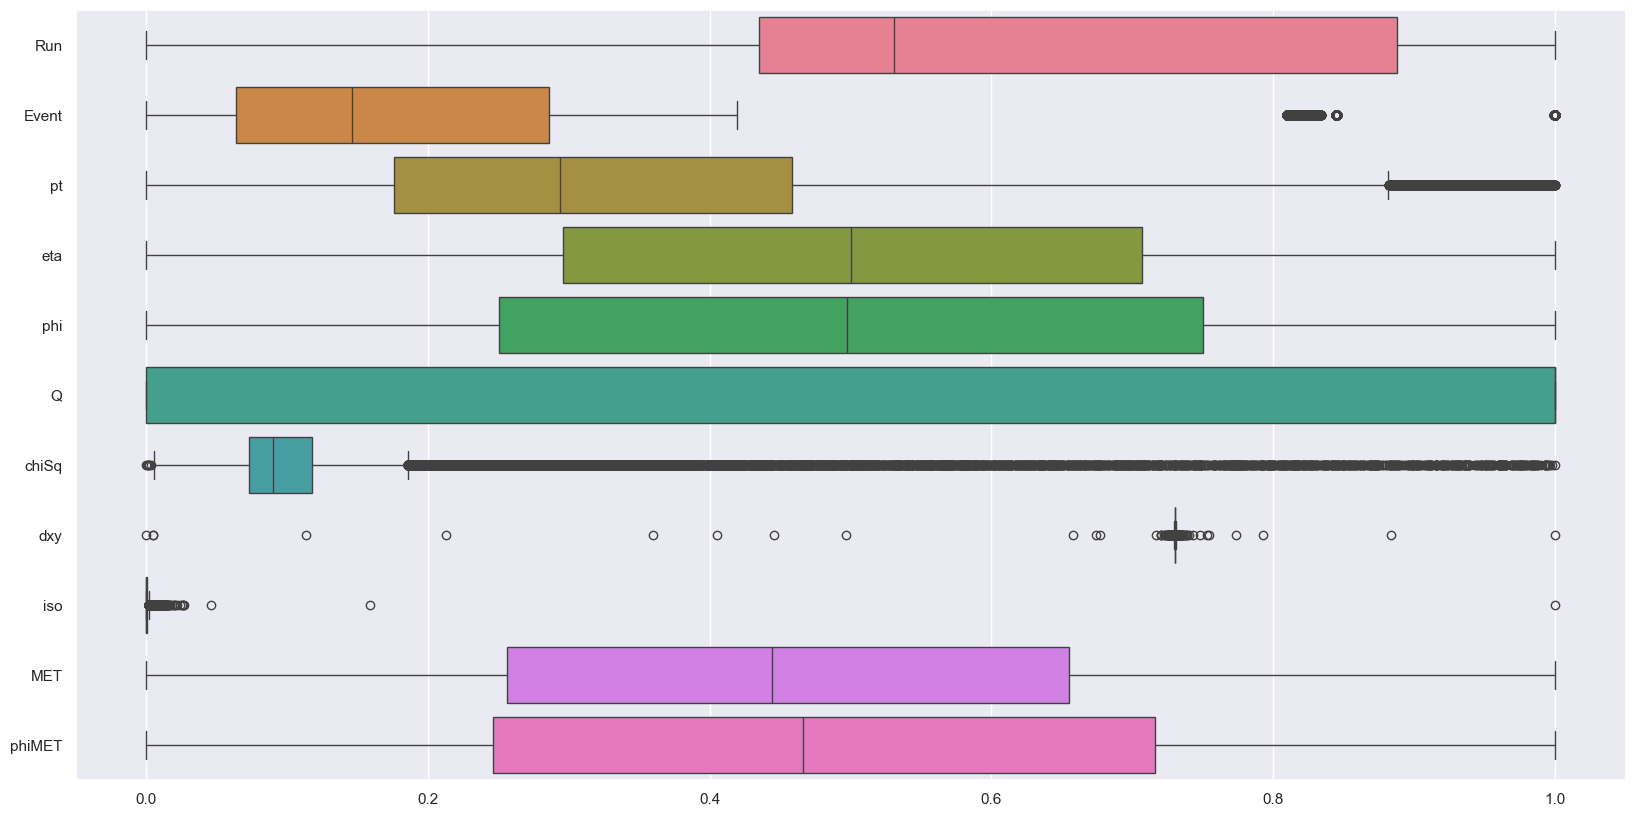

In [18]:
# boxplot again without the outliers
dfmunu_scaled_filtered = scaler.fit_transform(dfmunu_filtered)
dfmunu_filtered = pd.DataFrame(dfmunu_scaled_filtered, columns = dfmunu_filtered.columns)
# aesthetics
plt.figure(figsize=(20, 10)) 
sns.set(font_scale=1.0)
# boxplot
sns.boxplot(data=dfmunu_filtered, orient="h")

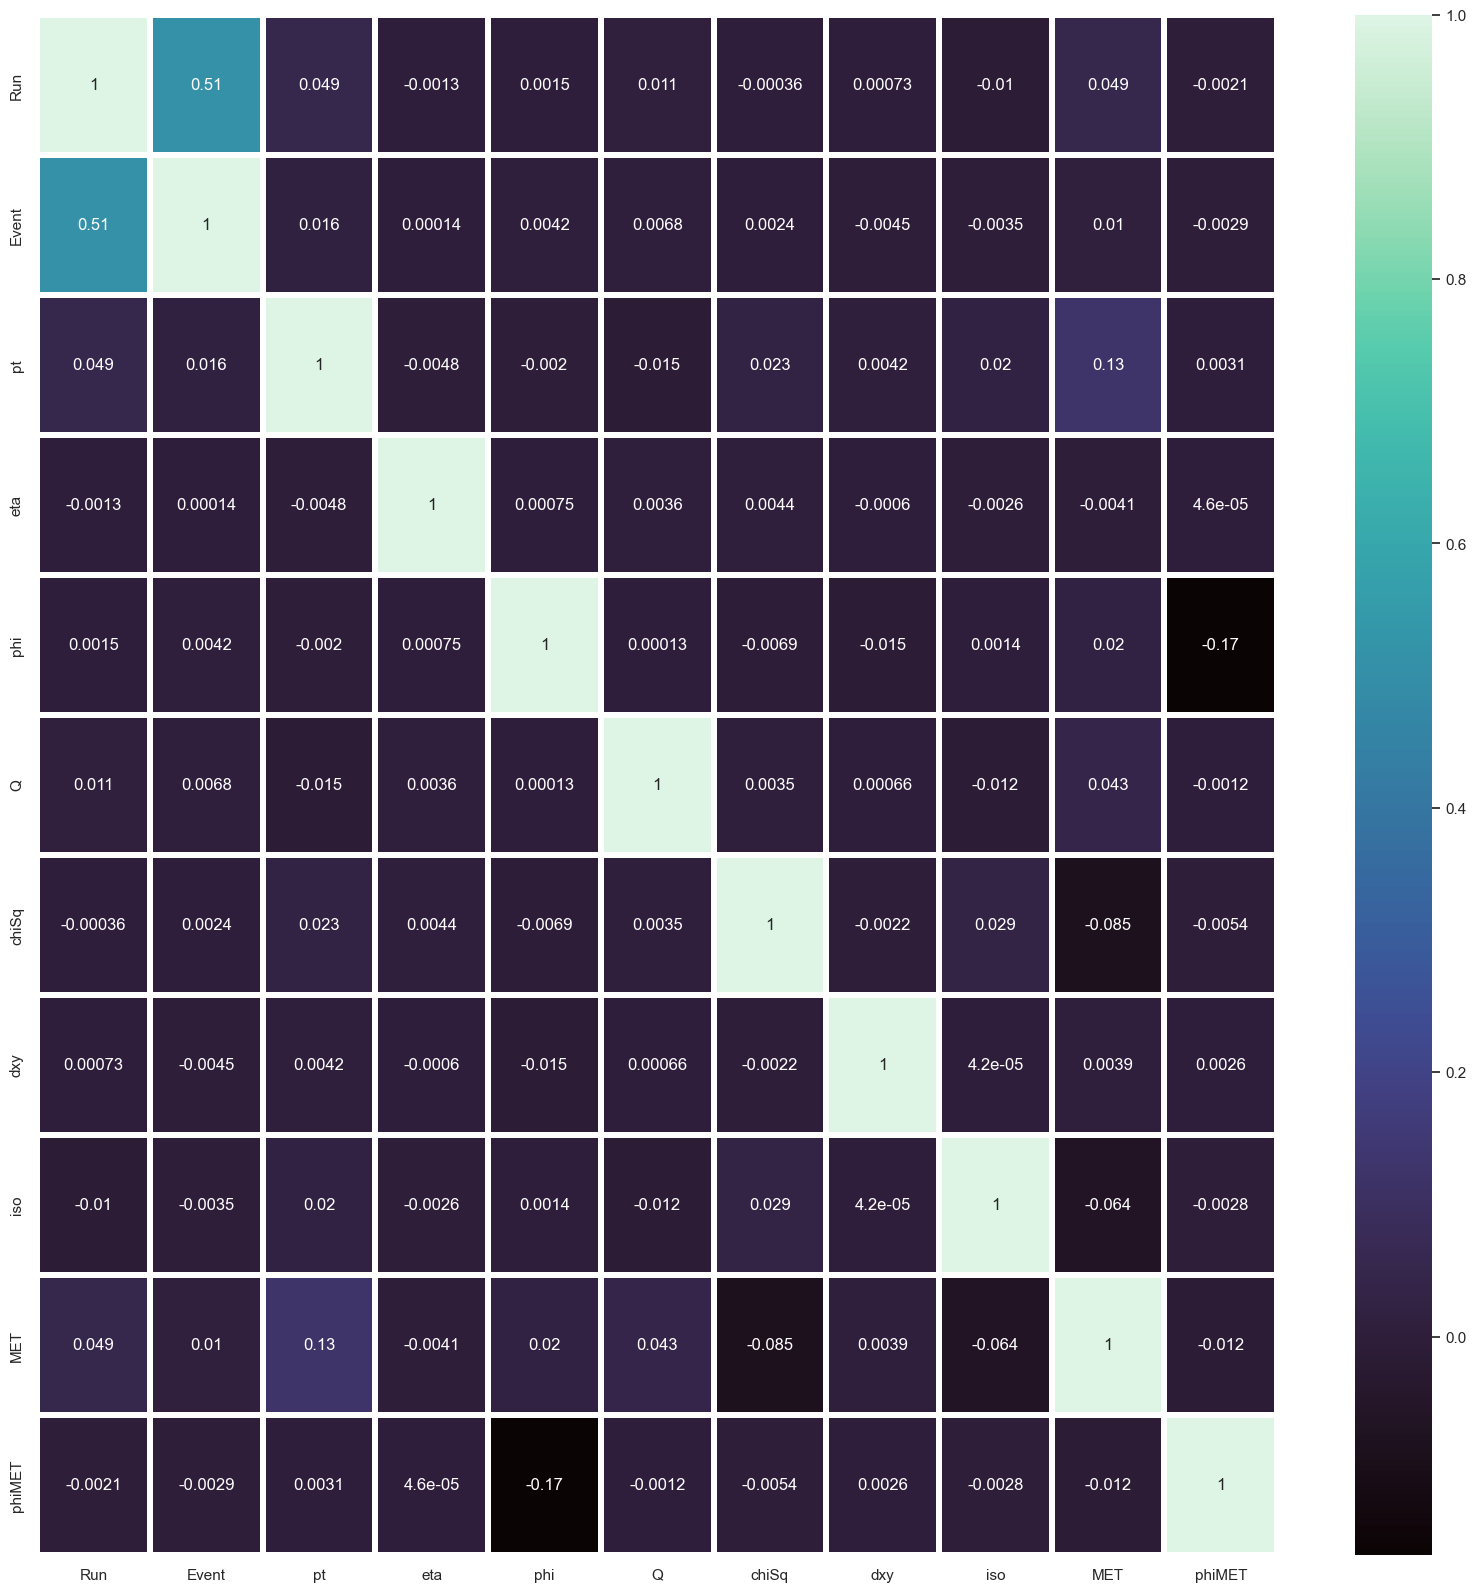

In [19]:
if data_checks=='y':
    fig, ax = plt.subplots(figsize=(20,20))
    sns.set(font_scale=1.0)
    sns.heatmap(df_munu.corr() , annot= True, linewidths=3, ax=ax, cmap='mako')

Stesso discorso di prima, non si osservano correlazioni (lineari!) evidenti tra le feature

### … then from the real dataframe

In [20]:
# again in preparation for future merging
df_mu = df_munu[['pt','eta','phi','Q','iso','MET','phiMET']]

if remove_outliers:
    cutoff_pt_mu = df_munu['pt'].quantile(.95)
    cutoff_MET_mu = df_munu['MET'].quantile(.95)
    df_mu = df_mu[(df_mu['pt']<cutoff_pt_mu) & (df_mu['MET']<cutoff_MET_mu)]

class_col = []
for i in range(len(df_mu['pt'])):
    class_col.append('munu')
    
df_mu.loc[:,'class'] = class_col

<Figure size 2000x1000 with 0 Axes>

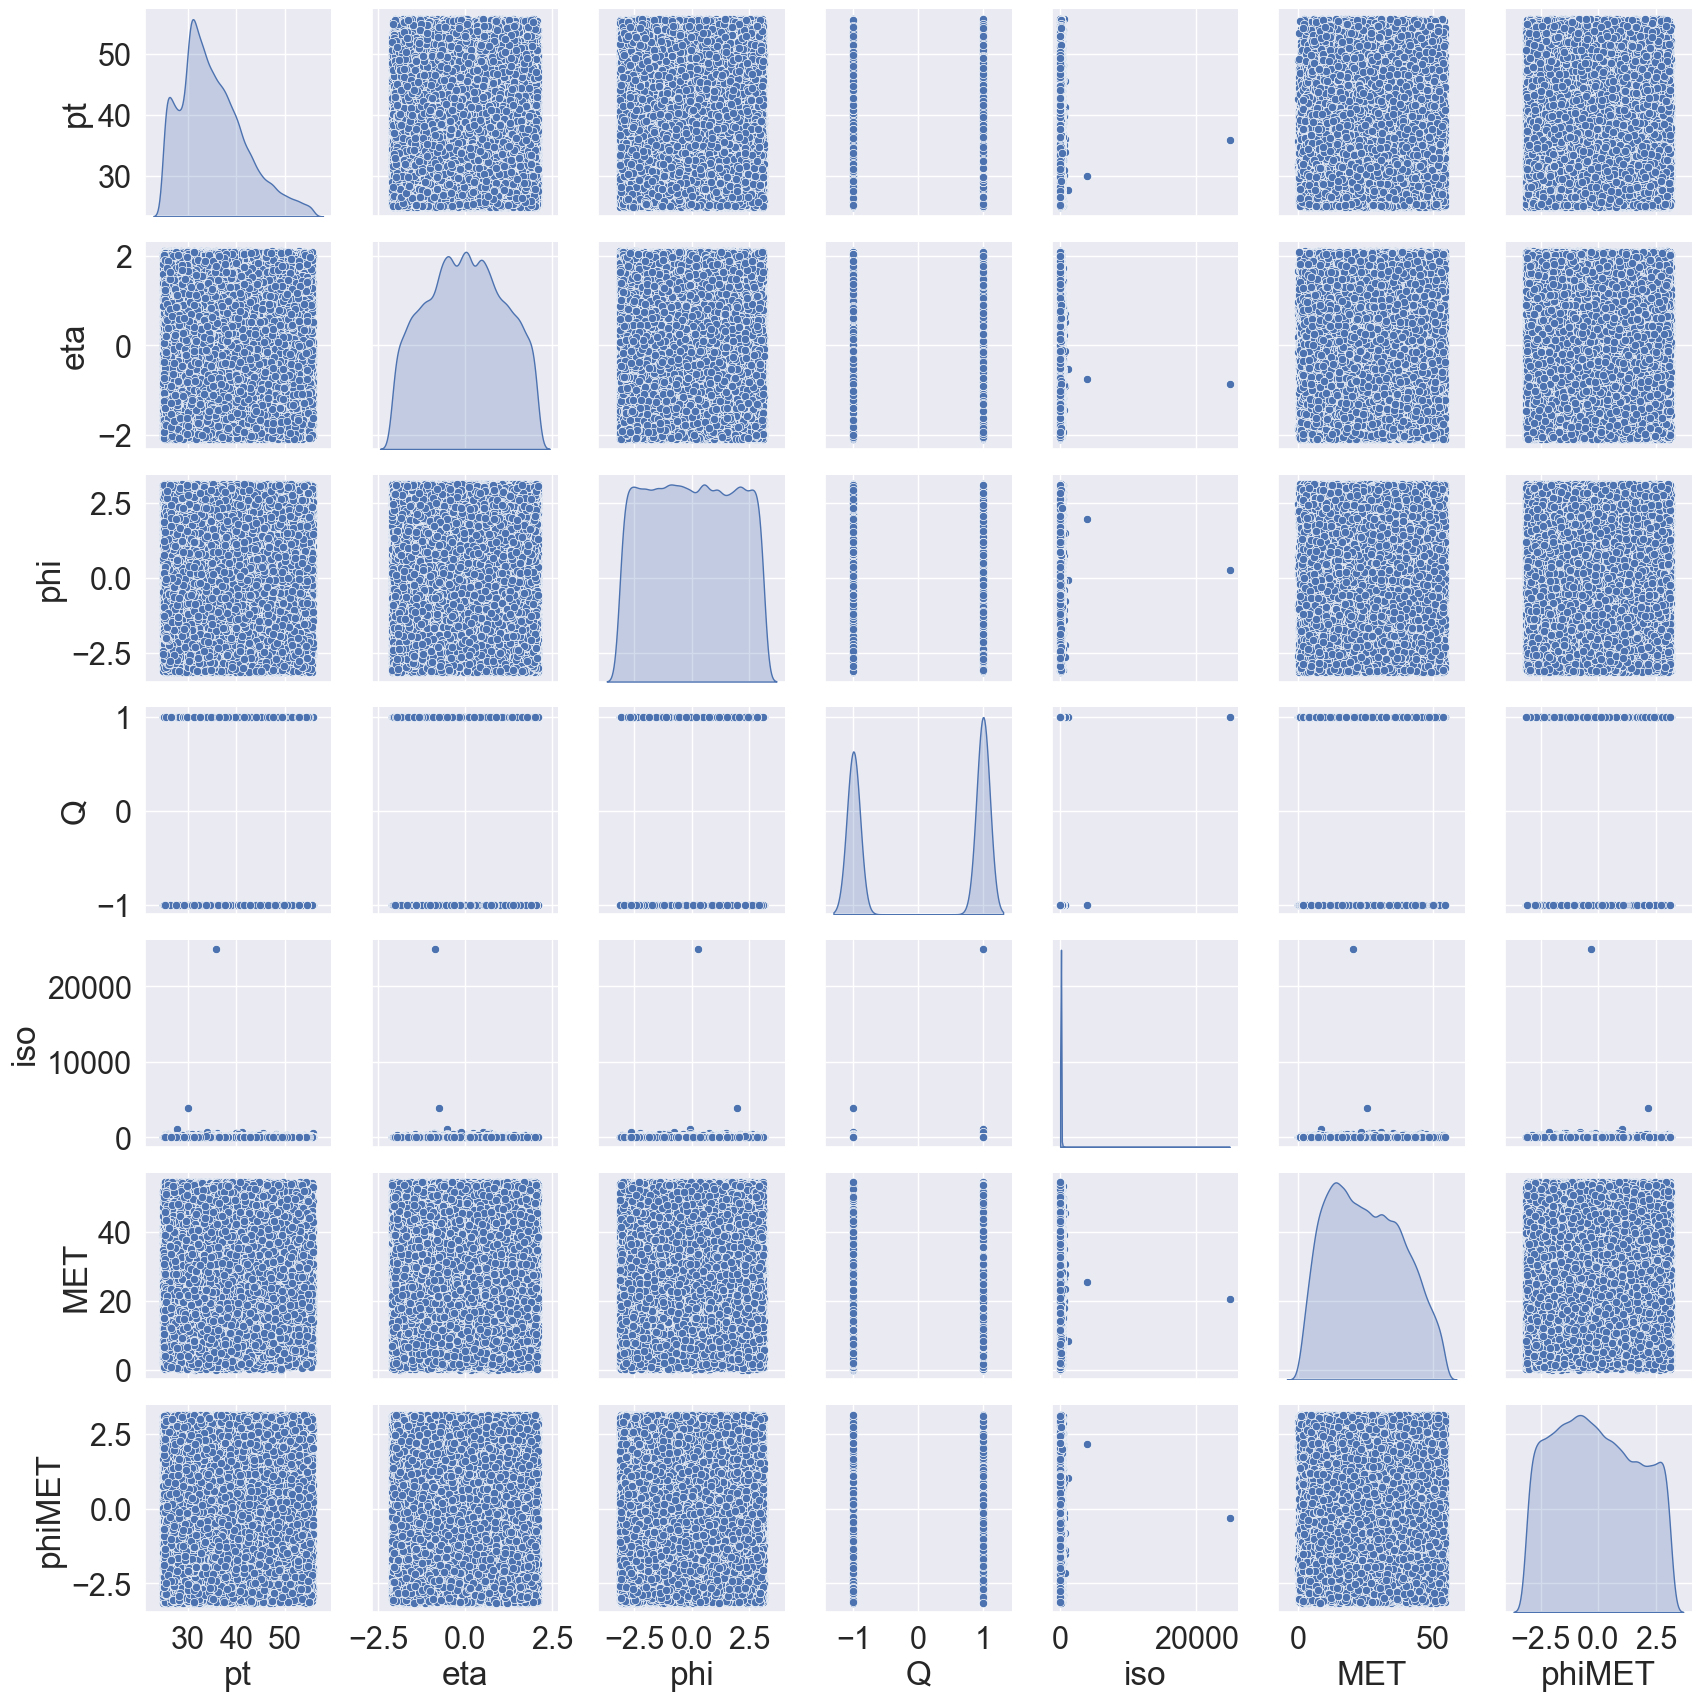

In [21]:
if data_checks=='y':
    # Already discarded unnecessary features (pairplot on df_mu, not df_munu)
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    sns.pairplot(df_mu, diag_kind='kde') # kde serve per avere le distribuzioni di probabilità (credo?)

# Merging data

In [22]:
del df_enu, df_munu # clean up

In [23]:
df = pd.concat([df_e,df_mu], ignore_index=True, sort=False)
df.sample(5)

pt     eta     phi  Q     iso      MET  phiMET class
121489  39.0188 -0.4342  1.8200 -1  8.1289  36.0030  1.7708  munu
119327  31.6116  1.8890 -1.6527  1  0.0000  31.6517  1.5072  munu
99206   55.6527  1.4077 -2.6031 -1  0.5786  43.5451  0.5212  munu
78373   37.9440  0.8491 -1.5709 -1  0.6636  26.8036  1.6913   enu
113782  32.9748  1.4739  1.7453  1  0.2737  27.6362 -1.1677  munu

In [24]:
del df_e, df_mu # clean up

## Data checks

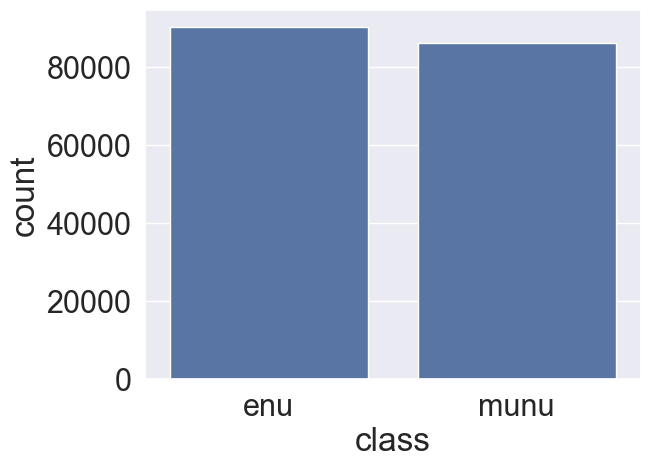

In [25]:
if data_checks=='y':
    # Per verificare che il dataset sia bilanciato
    sns.countplot(data=df,x='class')

**Merged Pairplot**: questo ha un'ulteriore utilità pké nonostante io abbia verificato che nn ci sono dipendenze evidenti separatamente tra le features, potenzialmente potrebbero esserci modi semplici di classificare sla base di poche feature (magari lo scatter tra 2 feature separa nettamente le 2 classi e quindi il problema di classificazione è immediatamente risolto). Effettivamente nn sembrano esserci maniere evidenti di risolvere il problema di classificazione a mano

## Dataframes to *train&test* the model

In [26]:
# Drop unnecessary features
df.drop(['iso','Q'], inplace=True, axis=1)

# map class to int
df['class'] = df['class'].map({'enu': 0, 'munu': 1})

In [27]:
# split labels from data
X = df.drop(['class'], axis=1)
y = df['class']

del df

In [28]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) # this outputs pandas

In [29]:
X_train.head(5)

pt     eta     phi      MET  phiMET
80623   64.0320  2.1130  2.6280  18.8360 -0.3797
25980   53.6347  1.2090  1.7389  18.7289  1.7811
88459   46.9111  2.2845  2.1415  15.4821 -0.0468
129340  40.0649 -1.4004 -3.1235  22.4505 -1.7030
171820  42.5995 -0.4345 -1.6350  34.9186  0.9710

# Feature engineering

In [30]:
if preproc_log=='y':
    X_train["log(pt)"] = X_train['pt'].apply(np.log1p) # questa roba qua fa ln(1 + x) -> credo sia solo per prendere le distanze dla potenziale divergenza in 0
    X_train["log(MET)"] = X_train['MET'].apply(np.log1p) 
    
    X_train.drop(['pt','MET'], inplace=True, axis=1)
    X_train.sample(5)

**Standardizzazione** (mi porto a media 0 e varianza 1, è trasf lineare NN sto forzando i dati a distribuirsi normalmente!)

In [31]:
# Costruiamo il layer e informiamolo (ie ho solo 1 forma/STRUTTURA che adatto ai dati MA NN LO STO POPOLANDO!)
X_train_scaler = tf.keras.layers.Normalization(axis=-1) # axis=-1 gli dice come leggere il tensor ie in quale direz calcolare medie e varianze (qua banalmente se sle righe (axis=0) o sle colonne (axis=-1 o axis=1 fa li stès))
X_train_scaler.adapt(tf.convert_to_tensor(X_train)) # qua informiamo il layer sui dati, ie si calcola medie e varianze che userà poi

X_test_scaler = tf.keras.layers.Normalization(axis=-1)
X_test_scaler.adapt(tf.convert_to_tensor(X_test))

# Building and testing model

In [32]:
def my_model():
   model = tf.keras.Sequential([
    X_train_scaler,
    tf.keras.layers.Dense(28, activation='sigmoid'),
    tf.keras.layers.Dense(28, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)       
   ])
   model.compile(
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
       # usiamo "Sparse" perché le classes nn sono rappresentate con one hot encoding ie (0,1) e (1,0) ma con interi ie 0 e 1
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])
   return model

model = my_model()

In [33]:
if model_testing=='y':
    history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test), batch_size=100)

Epoch 1/1000
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.6286 - loss: 0.6391 - val_accuracy: 0.6705 - val_loss: 0.5925
Epoch 2/1000
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 0.6742 - loss: 0.5838 - val_accuracy: 0.7129 - val_loss: 0.5594
Epoch 3/1000
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - accuracy: 0.7205 - loss: 0.5481 - val_accuracy: 0.7521 - val_loss: 0.5087
Epoch 4/1000
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - accuracy: 0.7520 - loss: 0.5043 - val_accuracy: 0.7516 - val_loss: 0.4972
Epoch 5/1000
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.7533 - loss: 0.4964 - val_accuracy: 0.7584 - val_loss: 0.4913
Epoch 6/1000
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1s 518us/step - accuracy: 0.7571 - loss: 0.4899 - val_accuracy: 0.7592 - val_loss: 0.4878
Epoch 7/1000
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.7576 - loss: 0.4873 - val_accuracy: 0.7606 - val_loss: 0.4851
Epoch 8/1000
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step - ac

In [34]:
if model_testing=='y':
    model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │           812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            58 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,127 (12.22 KB)

 Trainable params: 1,038 (4.05 KB)

 Non-trainable params: 11 (48.00 B)

 Optimizer params: 2,078 (8.12 KB)

## Performance check

Register
| model | the model learns? <br/> (y/n) | chiSq_th | preprocessing <br/> log (y/n)| scaler | model hidden <br/> layers (Dense) | batch size, epochs | max val_accuracy <br/> % |
|------|-----|-----|-------|------|------|----|-----|
| stupid | ? | 10 | n | keras.Norm | 128, 64 relu | (10, 100), 20 | 75? |
| learny | y | 10 | n | // | // | 50, 100 | 75 |
| overfitty | until epoch 100 <br/>(approx) | // | n | // | // | 100, 400 | 75 |
| 12864 | // | // | n | // | // | 100, 100 | 75 |
| 6464relu | y | // | n | n | 64,64 relu | 100, 100 | 75 |
| 6464sigm | y | // | n | n | 64,64 sigmoid | 100, 100 | 75 (1 po' meno del relu) |
| 2828sigm | y | // | n | n | 28,28 sigmoid | 100, 400 | 75 |
| 2828relu | y | // | n | n | 28,28 relu | 100, 700 | 75 |

al momento sembra che con la sigmoid il modello abbia meno problemi di overfitting ie il rapporto dle accuratezze è più vicino a 1 (lo vedi bene dle curve in foto)

it's convenient to use big batch sizes and many epochs in order to visualize the learning process in `history`. Moreover, don't worry about choosing `nepochs` in order to avoid overfitting because you record the entire learning process in the `history`

1104/1104 - 1s - 465us/step - accuracy: 0.7743 - loss: 0.4295


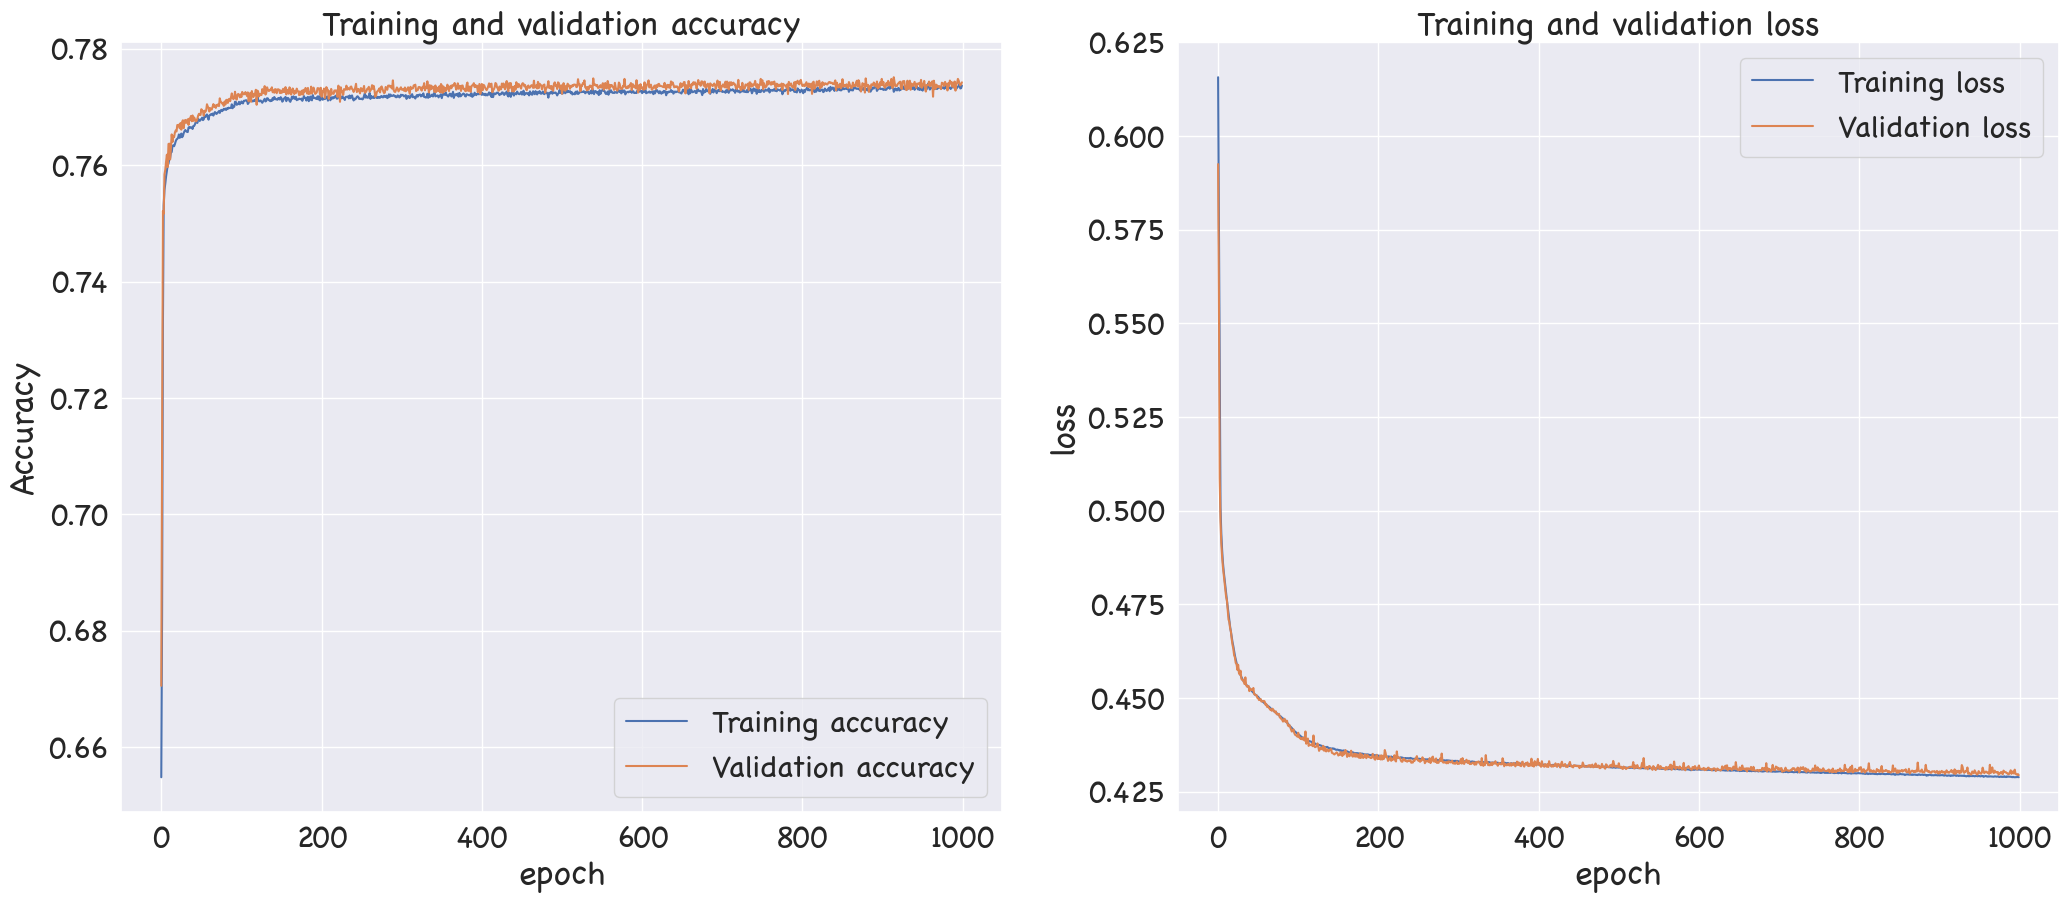

In [35]:
if model_testing=='y':
    # aesthetics
    font = {'family' : 'chalkboard',
            'weight' : 'bold',
            'size'   : 18}
    
    plt.rc('font', **font)
    
    fig = plt.figure(figsize=(25,10))
    ax1 = plt.subplot(121) # qsto sta per 1,2,1 ie nrows, ncol, index
    ax2 = plt.subplot(122)
    
    # what to plot on first figure (ax1)
    ax1.plot(history.history['accuracy'], label='Training accuracy') # qua specifico cosa plottare (le y, le x sono implicite in history)
    ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy') 
    
    ax1.set_title("Training and validation accuracy")
    ax1.set(xlabel='epoch', ylabel='Accuracy')
    ax1.legend(loc='lower right')
    
    # what to plot on first figure (ax1)
    ax2.plot(history.history['loss'], label='Training loss')
    ax2.plot(history.history['val_loss'], label='Validation loss')
    
    ax2.set_title("Training and validation loss")
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(loc='upper right')
    
    #To check the network accuracy on test data
    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [36]:
# fig.savefig('2828sigm700.png')